In [11]:
from pymongo import MongoClient
import pandas as pd 
import re
from collections import Counter
from konlpy.tag import Okt
from mecab import MeCab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # word embedding

# 네트워크 연결 규칙 : protocol://ip:port/path 
client = MongoClient('mongodb://192.168.0.50:27017/')

db_name = client["DB_SGMN"]
collection = db_name["COL_SCRAPPING_TOSS_COMMENT_HISTORY"]

In [12]:
find_data = collection.find()
data_list = list(find_data)

In [13]:
df_data = pd.DataFrame(data_list)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251836 entries, 0 to 251835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   _id         251836 non-null  object        
 1   COMMENT     251836 non-null  object        
 2   CREATED_AT  251836 non-null  datetime64[ns]
 3   DATE        251836 non-null  object        
 4   DATETIME    251836 non-null  object        
 5   SYMBOL      251836 non-null  object        
 6   UPDATED_AT  251836 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 13.4+ MB


In [14]:
df_data[:50000].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   _id         50000 non-null  object        
 1   COMMENT     50000 non-null  object        
 2   CREATED_AT  50000 non-null  datetime64[ns]
 3   DATE        50000 non-null  object        
 4   DATETIME    50000 non-null  object        
 5   SYMBOL      50000 non-null  object        
 6   UPDATED_AT  50000 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 2.7+ MB


In [15]:
# df_data[:50000].to_csv('output.csv', index=False)  # index=False로 인덱스 열 제외

In [16]:
mecab_inst = MeCab()

In [17]:
# 주차 계산을 위한 함수 정의
def get_week(date_str):
    # 정규 표현식으로 연도와 월, 일을 추출
    match = re.match(r'(\d{4})-(\d{2})-(\d{2})', date_str)
    if match:
        year, month, day = map(int, match.groups())
        # 날짜 객체 생성
        date = pd.Timestamp(year=year, month=month, day=day)
        # ISO 주차 반환
        return date.isocalendar()[1]  # 주차
    return None


In [18]:
# DATE 열에서 주차 계산
df_data['WEEK'] = df_data['DATE'].apply(get_week)
df_data['WEEK'].unique()
# # 주차별로 그룹화하여 집계 (예: VALUE의 합계)
# weekly_data = df_data.groupby(['WEEK']).agg({'COMMENT': ' '.join}).reset_index()

# # 결과 출력
# print(weekly_data)

array([47, 49, 50, 51, 52])

In [25]:
stopwords = ['건가요','가즈','이거','어디']   
ngramrange = (1,3)

[(617.4927421386377, '테슬라'), (437.3384732036836, '엔비디아'), (367.3322693511803, '오늘'), (270.15168386565404, '달러'), (259.1023060122849, '주식'), (214.8562612710121, '고점'), (211.7733650119793, '추매'), (184.09465844139515, '어디'), (182.24128488665698, '국장'), (179.61191247661608, '수익')]


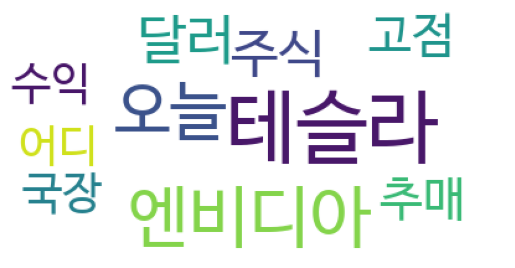

In [20]:
week = 49
df_week = df_data[df_data['WEEK'] == week]['COMMENT']
string_nouns = []
for text in df_week: 
    nouns_text = mecab_inst.nouns(text)
    filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]

    modify_nouns = ['엔비디아' if noun in ['엔비', '비디아'] else noun for noun in filtered_nouns]
    string_nouns.append(' '.join(modify_nouns))  # join() 메서드 사용
    
tfidfvectorizer = TfidfVectorizer(
    stop_words=stopwords, 
    ngram_range=ngramrange)
tfidfvectorizer.fit(string_nouns) # 학습
result_vectors = tfidfvectorizer.transform(string_nouns) 
tfidf_scores = result_vectors.toarray().sum(axis=0)
tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
print(tfidf_rank_10)
counter_dict = { word : score for score, word in tfidf_rank_10}
wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
wordcloud_instance.generate_from_frequencies(counter_dict) 
plt.imshow(wordcloud_instance)
plt.axis('off')
plt.show()

In [21]:
result_vectors.toarray().shape, tfidfvectorizer.get_feature_names_out().shape


((35427, 67876), (67876,))

In [22]:
tfidf_scores = result_vectors.toarray().sum(axis=0)

In [23]:
tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
tfidf_rank_10

[(617.4927421386377, '테슬라'),
 (437.3384732036836, '엔비디아'),
 (367.3322693511803, '오늘'),
 (270.15168386565404, '달러'),
 (259.1023060122849, '주식'),
 (214.8562612710121, '고점'),
 (211.7733650119793, '추매'),
 (184.09465844139515, '어디'),
 (182.24128488665698, '국장'),
 (179.61191247661608, '수익')]

[(7.872542193890651, '애플'), (5.166077273038156, '아처'), (3.938504286246629, '진입'), (3.3402095618421175, '추매'), (3.3155756270146606, '조비'), (3.115684886588695, '수익'), (3.0578077726424615, '평단'), (2.684816138267277, '달러'), (2.6251594038632176, '비중'), (2.623336723207134, '공매도')]


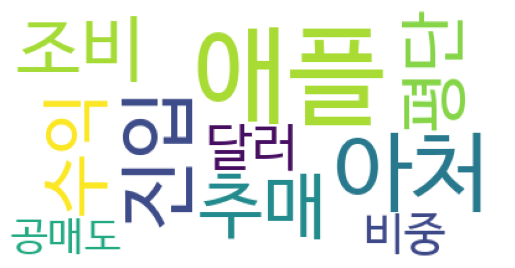

[(624.6009707580131, '테슬라'), (438.0927837871231, '엔비디아'), (367.3326573817896, '오늘'), (270.213260685426, '달러'), (259.2817376244605, '주식'), (221.90242173338171, '고점'), (211.7733650119793, '추매'), (182.51371637492323, '국장'), (179.63969074336077, '수익'), (176.1970074731019, '애플')]


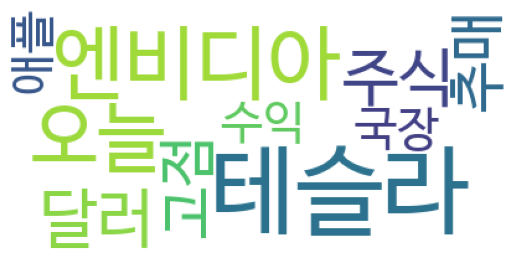

[(1305.4290368670772, '테슬라'), (765.8956573755909, '추매'), (740.4731957832862, '엔비디아'), (736.1607916273495, '조정'), (616.8280948740336, '오늘'), (491.77272637489165, '고점'), (443.1598030904431, '주식'), (399.6523321888535, '달러'), (305.1248856750533, '매수'), (303.00053058042266, '수익')]


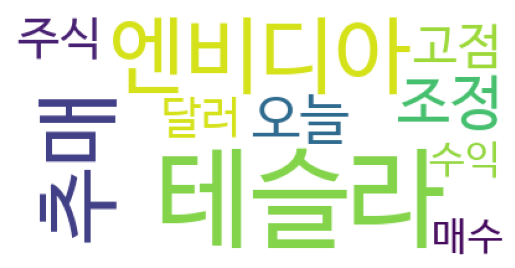

[(3172.689174797081, '테슬라'), (2323.475256046947, '추매'), (1720.9230433291648, '마녀'), (1621.3798212711608, '엔비디아'), (1349.7162635483742, '조정'), (1293.0547359193295, '오늘'), (1040.500455407211, '주식'), (969.8592461016658, '양전'), (948.5611618740111, '매수'), (887.1352287996682, '달러')]


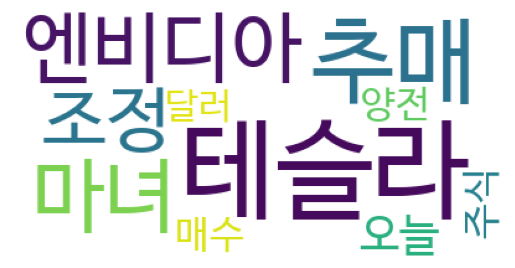

[(12.35808146097664, '엔비디아'), (12.229213417632637, '테슬라'), (11.782558824868625, '추매'), (9.591147888769513, '오늘'), (7.849926472135952, '애플'), (7.343395752356865, '산타랠리'), (5.169121149872142, '산타'), (4.950997993576533, '시작'), (4.901412504084325, '이번'), (4.751927797820168, '데이')]


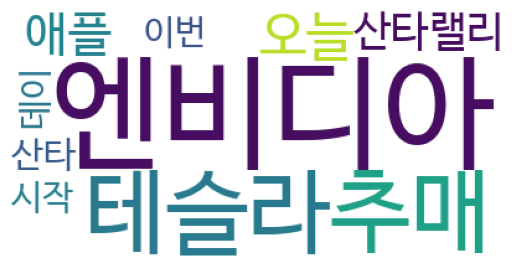

In [26]:
for week in df_data['WEEK'].unique():
    df_week = df_data[df_data['WEEK'] == week]['COMMENT']
    string_nouns = []
    for text in df_week: 
        nouns_text = mecab_inst.nouns(text)
        filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]
        modify_nouns = ['엔비디아' if noun in ['엔비', '비디아'] else noun for noun in filtered_nouns]
        string_nouns.append(' '.join(modify_nouns))  # join() 메서드 사용
        
    tfidfvectorizer = TfidfVectorizer(
        stop_words=stopwords, 
        ngram_range=ngramrange)
    tfidfvectorizer.fit(string_nouns) # 학습
    result_vectors = tfidfvectorizer.transform(string_nouns) 
    tfidf_scores = result_vectors.toarray().sum(axis=0)
    tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
    print(tfidf_rank_10)

    counter_dict = { word : score for score, word in tfidf_rank_10}

    wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
    wordcloud_instance.generate_from_frequencies(counter_dict) 

    plt.imshow(wordcloud_instance)
    plt.axis('off')
    plt.show()